## Option Pricing

In [105]:
import yfinance as yfin
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

yfin.pdr_override()

# List of stock symbols
ticker = 'META'

# Set the date range for the historical data
start_date = '2020-08-01'
end_date = '2023-08-01'

# Download historical stock data for each stock

stock = pdr.get_data_yahoo(ticker, start_date, end_date)



[*********************100%%**********************]  1 of 1 completed


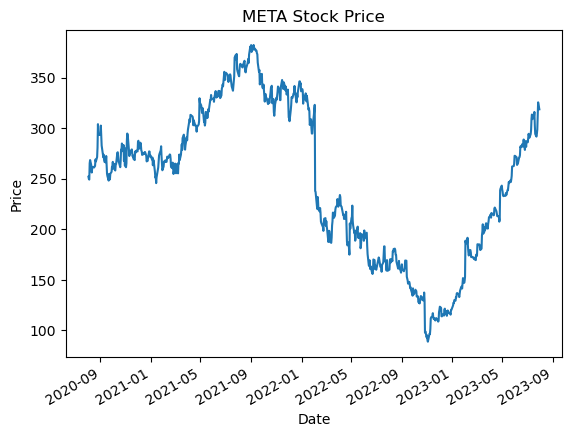

In [106]:
# Plot the stock price
stock['Close'].plot(ylabel='Price',title=f"{ticker} Stock Price")
plt.show()

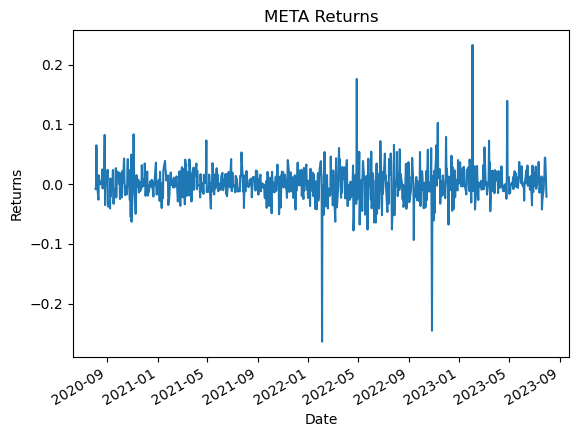

In [107]:
stock['Returns'] = stock['Close'].pct_change()


stock['Returns'].plot(ylabel='Returns',title=f"{ticker} Returns")
plt.show()


In [108]:
from statsmodels.tsa.stattools import adfuller
# Testing stationarity
stat_test = adfuller(stock['Returns'].dropna())[0:2]
print(f"The test statistic and p-value of ADF test are {stat_test}")
if stat_test[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is not stationary")


The test statistic and p-value of ADF test are (-27.36131688520551, 0.0)
The data is stationary


### Estimating volatility

Use weighted returns to calculate the volatility from the historical data.
Exponential weighted moving average can be used get an estimate

$\sigma_{n}=(1-\lambda)\Sigma_{1}^{\inf}\lambda^{i-1}R^{2}_{n-i+1}$

Analysing with three values of $\lambda=0.85,0.9,0.95$

In [112]:
import numpy as np 

def get_volatility(returns,j,lmb):
    N=returns.shape[0]
    sig=0
    for i in range(1,N):
        sig += (lmb**(i-1))*returns[j-i+1]**2
    sig *= (1-lmb)
    return sig

stock['Returns'].fillna(0,inplace=True)

stock['EMAV85'] = 0
stock['EMAV90'] = 0
stock['EMAV95'] = 0

# vol = np.zeros(len(stock['Returns']))
for j in range(len(stock['Returns'])):
    stock['EMAV85'].iat[j] = np.sqrt(get_volatility(stock['Returns'].values,j,0.85))
    stock['EMAV90'].iat[j] = np.sqrt(get_volatility(stock['Returns'].values,j,0.90))
    stock['EMAV95'].iat[j] = np.sqrt(get_volatility(stock['Returns'].values,j,0.95))


<Axes: xlabel='Date'>

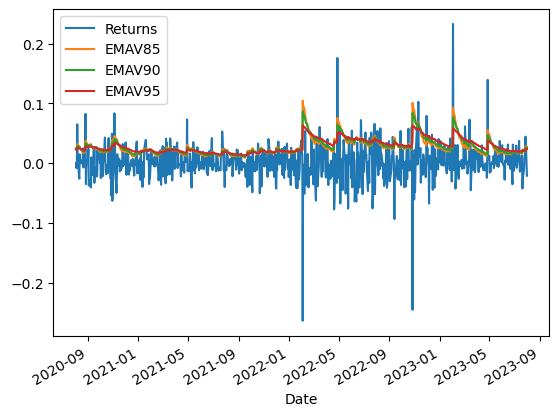

In [114]:
stock[['Returns','EMAV85','EMAV90','EMAV95']].plot()


For low values of lambda EWMA is more reactive to big market events but the high volatility dies quickly.
It is a good idea to check the values by setting lambda close to one. The low values of lambda in a period of low volatility can give you low values of volatility, this value can be misleading. Extreme events can occur in future. The high value of lambda can be used as a limiting case of volatility.

### Variation with volatility

In [111]:
for sigma in 
# options
strike_price = 105
risk_free_rate = 0.05
Expiry = 0.2
t=0.1
models = Pricing_Models(strike_price, risk_free_rate, Expiry, volatility,dt)
option_price = models.binomial_pricing(stock.prices[0],t)

print("Option price:", option_price)

SyntaxError: invalid syntax (2867008270.py, line 1)